# Offshore CIOPS Quantitative Runs
### what if using huyer 1998's divisions was a good idea...

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import datetime as dt
import math
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor as LOF

In [2]:
# round to 2 sig fig
def round_to_2(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+1)

def round_to_3(x):
    return np.round(x, -int(math.floor(math.log10(abs(x))))+2)

In [3]:
meander = 0
init = 1
North = 2
Sshelf = 5
Sslope = 4
Offshore = 3
# sections = [North, Sshelf, Sslope, Offshore, meander]
# sec_name = ['north', 'south\nshelf', 'south\nslope', 'offshore', 'meander']

In [4]:
saltdiv = 32

tide = 24
offcut = 595 

#from huyer 1998, Masson 2006, and Sahu 2022
sdiv = 33.9

## summer 2017

In [5]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')

In [6]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

monS = ['apr', 'may', 'jun', 'jul', 'aug', 'sep']
mon_len = [30, 31, 30, 31, 31, 30]
h = 3601
sum_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
sum_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [7]:
mon_sum_ = [np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]

loop_ = [np.sum(data.init_transp[(data.final_section==meander) & (data.init_t-data.final_t > tide) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in range(len(sum_start))]
mon_sum = np.array(loop_)+np.array(mon_sum_)
loop = np.array(loop_)/np.array(mon_sum)

In [8]:
north = [np.sum(data.init_transp[(data.final_section==North) & (data.init_t >= sum_start[i]) 
                                 & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                 for i in range(len(sum_start))]

offshore = [np.sum(data.init_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) 
                                    & (data.final_x <= offcut) & (data.init_t >= sum_start[i]) 
                                    & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                    for i in range(len(sum_start))]

cuc = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                               & (data.final_x > offcut) & (data.final_salt >= sdiv)
                               & (data.init_t >= sum_start[i])
                               & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                               for i in range(len(sum_start))]

south = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                                 & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv)
                                 & (data.init_t >= sum_start[i]) 
                                 & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                 for i in range(len(sum_start))]

fresh = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & 
                                 (data.final_x > offcut) & (data.final_salt < saltdiv) & 
                                 (data.init_t >= sum_start[i]) & 
                                 (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i] 
                                 for i in range(len(sum_start))]

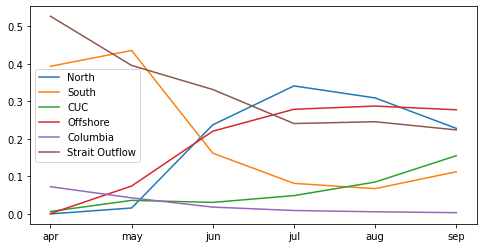

In [9]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(monS, north, label = "North")
ax.plot(monS, south, label = "South")
ax.plot(monS, cuc, label = "CUC")
ax.plot(monS, offshore, label='Offshore')
ax.plot(monS, fresh, label = "Columbia")
ax.plot(monS, loop, label = "Strait Outflow")

# ax.plot(monS, meander, label = "Strait Outflow")
ax.legend()

In [10]:
total = np.sum(mon_sum[2:])

north_bar = np.sum([north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100])
offshore_bar = np.sum([offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100])
cuc_bar = np.sum([cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100])
south_bar = np.sum([south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100]) 
fresh_bar = np.sum([fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100]) 
loop_bar = np.sum([loop[2]*mon_sum[2]/total*100, loop[3]*mon_sum[3]/total*100, loop[4]*mon_sum[4]/total*100, loop[5]*mon_sum[5]/total*100]) 

Text(0, 0.5, 'Percentage of JdF Inflow')

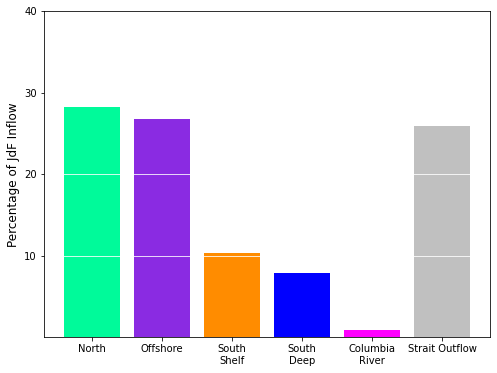

In [11]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'South\nDeep', 'Columbia\nRiver', 'Strait Outflow']
colors = ['mediumspringgreen', 'blueviolet','darkorange', 'b', 'magenta', 'silver']
ax.bar(sec_name,[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar, loop_bar], color=colors)
ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [12]:
# percentages w/out loop
total_bar = sum([north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar])
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]/total_bar*100

array([38.0713216 , 36.06403143, 13.98005734, 10.68170597,  1.20288366])

In [14]:
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar,loop_bar]

[28.217819997670276,
 26.730050451880974,
 10.36178217776439,
 7.917099897567929,
 0.8915570329697492,
 25.8816904421467]

### Sv calcs

In [15]:
print('north = '+ str(np.mean(north[2:]*mon_sum[2:]/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore[2:]*mon_sum[2:]/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc[2:]*mon_sum[2:]/1000)) + ' mSv')
print('south = '+ str(np.mean(south[2:]*mon_sum[2:]/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh[2:]*mon_sum[2:]/1000)) + ' mSv')
print('loop = '+ str(np.mean(loop[2:]*mon_sum[2:]/1000)) + ' mSv')

north = 28.785348272370243 mSv
offshore = 27.267656100256776 mSv
cuc = 8.076331831355338 mSv
south = 10.570182556058995 mSv
fresh = 0.909488390699004 mSv
loop = 26.402233528896954 mSv


In [10]:
10.570182556058995+0.909488390699004+8.076331831355338

19.55600277811334

In [16]:
indep = -150

print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= sdiv) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= sdiv) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('\n')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('\n')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('\n')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > indep) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')
print('\n')
print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (abs(data.init_t-data.final_t)<24) & (data.init_t >= sum_start[i]) & (data.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [2,3,4,5]])/1000) + ' mSv')

cuc deep = 1.3225086012548828 mSv


cuc shallow = 6.753823230100454 mSv


south deep = 2.3045141582603277 mSv
south shallow = 8.265668397798665 mSv


offshore deep = 5.523222024172333 mSv
offshore shallow = 21.744434076084442 mSv
offshore start deep = 11.90724300570464 mSv


north deep = 5.453324707426038 mSv
north shallow = 23.332023564944205 mSv


meander = 325.7043177193855 mSv


## winter 2016/17

In [17]:
dataS= xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')

In [18]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon16 = ['oct16', 'nov16', 'dec16', 'jan17', 'feb17', 'mar17']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [19]:
mons = np.append(mon16, ['apr17', 'may17'])

mon_sum_ = np.append([np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))],
                    [np.sum(dataS.final_transp[(dataS.final_section!=0) & (np.isnan(dataS.final_section)==False) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0,1]])

loop_ = np.append([np.sum(data.final_transp[(data.final_section==0) & (data.init_t-data.final_t > tide) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==0) & (dataS.init_t-dataS.final_t > tide) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1) for i in [0,1]])
mon_sum = loop_+mon_sum_
loop = loop_/mon_sum

In [20]:
cuc = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut)  & (data.final_salt >= sdiv) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_x > offcut) & (dataS.final_salt >= sdiv) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

south = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt < sdiv) & (data.final_salt >= saltdiv) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_x > offcut) & (dataS.final_salt < sdiv) & (dataS.final_salt >= saltdiv) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

fresh = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut)  & (data.final_salt < saltdiv) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Sshelf),(dataS.final_section==Sslope)) & (dataS.final_x > offcut) & (dataS.final_salt < saltdiv)  & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])
north = np.append([np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[(dataS.final_section==North) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

offshore = np.append([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))],
                  [np.sum(dataS.final_transp[np.logical_or((dataS.final_section==Offshore),(dataS.final_section==Sslope)) & (dataS.final_x <= offcut) & (dataS.init_t >= sum_start[i]) & (dataS.init_t <= sum_end[i])])/(sum_end[i]-sum_start[i]+1)/mon_sum[i+6] for i in [0,1]])

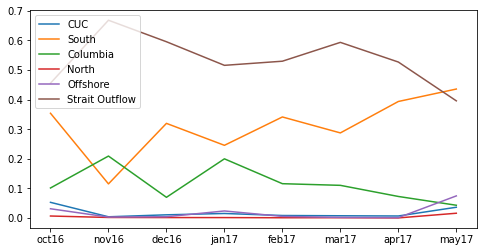

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mons, cuc, label = "CUC")
ax.plot(mons, south, label = "South")
ax.plot(mons, fresh, label = "Columbia")
ax.plot(mons, north, label = "North")
ax.plot(mons, offshore, label = "Offshore")
ax.plot(mons, loop, label = "Strait Outflow")

ax.legend()

In [22]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100,cuc[6]*mon_sum[6]/total*100,cuc[7]*mon_sum[7]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100,south[6]*mon_sum[6]/total*100,south[7]*mon_sum[7]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100,fresh[6]*mon_sum[6]/total*100,fresh[7]*mon_sum[7]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100,north[6]*mon_sum[6]/total*100,north[7]*mon_sum[7]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100,offshore[6]*mon_sum[6]/total*100,offshore[7]*mon_sum[7]/total*100])
loop_bar = np.sum([loop[0]*mon_sum[0]/total*100, loop[1]*mon_sum[1]/total*100, loop[2]*mon_sum[2]/total*100, loop[3]*mon_sum[3]/total*100, loop[4]*mon_sum[4]/total*100, loop[5]*mon_sum[5]/total*100,loop[6]*mon_sum[6]/total*100,loop[7]*mon_sum[7]/total*100])


Text(0, 0.5, 'Percentage of JdF Inflow')

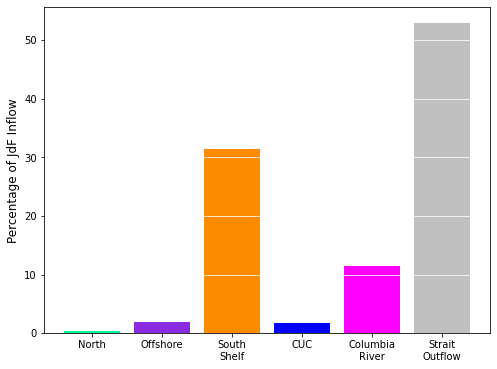

In [23]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = [ 'North', 'Offshore', 'South\nShelf', 'CUC', 'Columbia\nRiver', 'Strait\nOutflow']
# colors = ['teal',  'teal',  'teal', 'teal', 'teal']
colors = ['mediumspringgreen', 'blueviolet','darkorange', 'b', 'magenta', 'silver']
ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar, loop_bar], color=colors)
# ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [24]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar,loop_bar]

[0.35647108989160503,
 1.8987511261148766,
 31.504153349033412,
 1.7652756044378521,
 11.449376829737226,
 53.02597200078504]

In [25]:
cuc_bar,fresh_bar

(1.7652756044378521, 11.449376829737226)

In [26]:
# percentages w/out loop
total_bar = sum([north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar])
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]/total_bar*100

array([ 0.75886847,  4.04212968, 67.06717454,  3.75798219, 24.37384512])

In [27]:
np.sum([north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar,loop_bar])

100.00000000000001

### Sv

In [28]:
print('north = '+ str(np.mean(north*mon_sum/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore*mon_sum/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc*mon_sum/1000)) + ' mSv')
print('south = '+ str(np.mean(south*mon_sum/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh*mon_sum/1000)) + ' mSv')
print('loop = '+ str(np.mean(loop*mon_sum/1000)) + ' mSv')

north = 0.3141154630447319 mSv
offshore = 1.6731429451057054 mSv
cuc = 1.5555268845453254 mSv
south = 27.760853538145295 mSv
fresh = 10.088970484366984 mSv
loop = 46.72546588136611 mSv


In [11]:
27.760853538145295+1.5555268845453254+10.088970484366984

39.4053509070576

## winter 2017/18

In [29]:
data = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')

In [30]:
# init_t 3601 refers to the first hour of day 150 = 2017/04/01
# init_t 7992 refers to the last hour of day 333 = 2017/09/30
# the run itself starts on 7992

mon17 = ['oct17', 'nov17', 'dec17', 'jan18', 'feb18', 'mar18']
mon_len = [31, 30, 31, 31, 28, 31]
h = 3601
win_start = [h, h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24]
win_end = [h+sum(mon_len[:1])*24, h+sum(mon_len[:2])*24, h+sum(mon_len[:3])*24, h+sum(mon_len[:4])*24, h+sum(mon_len[:5])*24, h+sum(mon_len)*24-1]

In [31]:
mon_sum_ = [np.sum(data.final_transp[(data.final_section!=0) & (np.isnan(data.final_section)==False) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))]

loop_ = [np.sum(data.init_transp[(data.final_section==meander) & (data.init_t-data.final_t > tide) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(win_start))]
mon_sum = np.array(loop_)+np.array(mon_sum_)
loop = np.array(loop_)/np.array(mon_sum)

In [32]:
cuc = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                               & (data.final_x > offcut) & (data.final_salt >= sdiv)
                               & (data.init_t >= win_start[i])
                               & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] 
                               for i in range(len(win_start))]

south = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) 
                                 & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv)
                                 & (data.init_t >= win_start[i]) 
                                 & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] 
                                 for i in range(len(win_start))]

fresh = [np.sum(data.init_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & 
                                 (data.final_x > offcut) & (data.final_salt < saltdiv) & 
                                 (data.init_t >= win_start[i]) & 
                                 (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] 
                                 for i in range(len(win_start))]

north = [np.sum(data.final_transp[(data.final_section==North) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]
offshore = [np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1)/mon_sum[i] for i in range(len(win_start))]

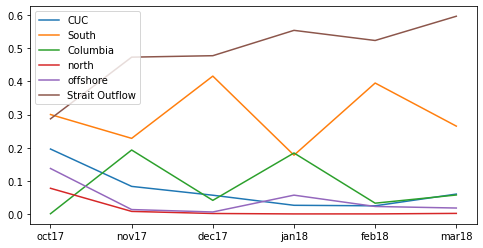

In [33]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(mon17, cuc, label = "CUC")
ax.plot(mon17, south, label = "South")
ax.plot(mon17, fresh, label = "Columbia")
ax.plot(mon17, north, label = "north")
ax.plot(mon17, offshore, label = "offshore")
ax.plot(mon17, loop, label = "Strait Outflow")


ax.legend()

In [34]:
total = np.sum(mon_sum)
cuc_bar = np.sum([cuc[0]*mon_sum[0]/total*100, cuc[1]*mon_sum[1]/total*100, cuc[2]*mon_sum[2]/total*100, cuc[3]*mon_sum[3]/total*100, cuc[4]*mon_sum[4]/total*100, cuc[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
south_bar = np.sum([south[0]*mon_sum[0]/total*100, south[1]*mon_sum[1]/total*100, south[2]*mon_sum[2]/total*100, south[3]*mon_sum[3]/total*100, south[4]*mon_sum[4]/total*100, south[5]*mon_sum[5]/total*100]) #,cuc[6]*mon_sum[6]/total*100])
fresh_bar = np.sum([fresh[0]*mon_sum[0]/total*100, fresh[1]*mon_sum[1]/total*100, fresh[2]*mon_sum[2]/total*100, fresh[3]*mon_sum[3]/total*100, fresh[4]*mon_sum[4]/total*100, fresh[5]*mon_sum[5]/total*100])
north_bar = np.sum([north[0]*mon_sum[0]/total*100, north[1]*mon_sum[1]/total*100, north[2]*mon_sum[2]/total*100, north[3]*mon_sum[3]/total*100, north[4]*mon_sum[4]/total*100, north[5]*mon_sum[5]/total*100])
offshore_bar = np.sum([offshore[0]*mon_sum[0]/total*100, offshore[1]*mon_sum[1]/total*100, offshore[2]*mon_sum[2]/total*100, offshore[3]*mon_sum[3]/total*100, offshore[4]*mon_sum[4]/total*100, offshore[5]*mon_sum[5]/total*100])
loop_bar = np.sum([loop[0]*mon_sum[0]/total*100, loop[1]*mon_sum[1]/total*100, loop[2]*mon_sum[2]/total*100, loop[3]*mon_sum[3]/total*100, loop[4]*mon_sum[4]/total*100, loop[5]*mon_sum[5]/total*100])


Text(0, 0.5, 'Percentage of JdF Inflow')

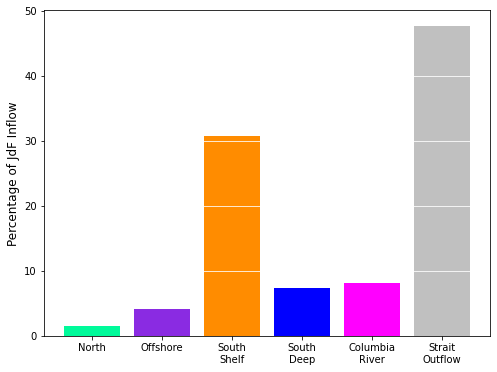

In [35]:
#bar plot of contribution for june, july, august, september
fig, ax = plt.subplots(1,1,figsize=(8,6))
sec_name = ['North', 'Offshore', 'South\nShelf', 'South\nDeep', 'Columbia\nRiver', 'Strait\nOutflow']
# colors = ['teal',  'teal',  'teal', 'teal', 'teal']
colors = ['mediumspringgreen', 'blueviolet','darkorange', 'b', 'magenta', 'silver']

ax.bar(sec_name,[north_bar, offshore_bar, south_bar ,cuc_bar, fresh_bar, loop_bar], color=colors)
# ax.yaxis.set_ticks([10,20,30,40])
ax.grid(axis = 'y', color='white')
ax.set_ylabel('Percentage of JdF Inflow', fontsize=12)

In [36]:
[north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar,loop_bar]

[1.558714647968228,
 4.226084122159593,
 30.763756608473315,
 7.489403945263629,
 8.186300136184443,
 47.77574053995079]

In [37]:
cuc_bar, fresh_bar

(7.489403945263629, 8.186300136184443)

In [38]:
np.sum([north_bar, offshore_bar, south_bar ,cuc_bar,fresh_bar,loop_bar])

100.0

In [39]:
# percentages w/out loop
total_bar = sum([north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar])
[north_bar,offshore_bar, south_bar,cuc_bar, fresh_bar]/total_bar*100

array([ 2.9846563 ,  8.09218583, 58.90702315, 14.34085236, 15.67528237])

### Sv

In [40]:
print('north = '+ str(np.mean(north*mon_sum/1000)) + ' mSv')
print('offshore = '+ str(np.mean(offshore*mon_sum/1000)) + ' mSv')
print('cuc = '+ str(np.mean(cuc*mon_sum/1000)) + ' mSv')
print('south = '+ str(np.mean(south*mon_sum/1000)) + ' mSv')
print('fresh = '+ str(np.mean(fresh*mon_sum/1000)) + ' mSv')
print('loop = '+ str(np.mean(loop*mon_sum/1000)) + ' mSv')

north = 1.3802585523807227 mSv
offshore = 3.742242853940292 mSv
cuc = 6.631947586531417 mSv
south = 27.241636702107773 mSv
fresh = 7.249056644237278 mSv
loop = 42.30593108401561 mSv


In [12]:
27.241636702107773+7.249056644237278+6.63194758653141

41.122640932876465

In [42]:
indep = -150

print('cuc deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= sdiv) & (data.init_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('cuc shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= sdiv) & (data.init_depth > indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('\n')
print('south deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv) & (data.init_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('south shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Sshelf),(data.final_section==Sslope)) & (data.final_x > offcut) & (data.final_salt >= saltdiv) & (data.final_salt < sdiv) & (data.init_depth > indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('\n')
print('offshore deep = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('offshore shallow = '+ str(np.mean([np.sum(data.final_transp[np.logical_or((data.final_section==Offshore),(data.final_section==Sslope)) & (data.final_x <= offcut) & (data.init_depth > indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('offshore start deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==Offshore) & (data.final_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('\n')
print('north deep = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth <= indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('north shallow = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==North) & (data.init_depth > indep) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')
print('\n')
print('meander = '+ str(np.mean([np.sum(data.final_transp[(data.final_section==0) & (abs(data.init_t-data.final_t)<24) & (data.init_t >= win_start[i]) & (data.init_t <= win_end[i])])/(win_end[i]-win_start[i]+1) for i in range(len(mon17))])/1000) + ' mSv')

cuc deep = 1.4086036541897902 mSv
cuc shallow = 5.223343932341625 mSv


south deep = 7.395041034943935 mSv
south shallow = 19.84659566716384 mSv


offshore deep = 0.7375575533565663 mSv
offshore shallow = 3.0046853005837257 mSv
offshore start deep = 0.2065677603109697 mSv


north deep = 0.23252147700108663 mSv
north shallow = 1.1477370753796363 mSv


meander = 350.67567850727056 mSv


# bring it all together

In [7]:
mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope) & (mydata.final_x > offcut)) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north16 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Offshore),(mydata.final_section==Sslope)) & (mydata.final_x <= offcut) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
loop16 = [np.sum(mydata.final_transp[(mydata.final_section==0) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
 

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(183)]

freshS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt < saltdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cucS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
southS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
northS = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshoreS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Offshore),(mydata.final_section==Sslope)) & (mydata.final_x <= offcut) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
loopS = [np.sum(mydata.final_transp[(mydata.final_section==0) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]


mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

fresh17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt < saltdiv)& (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
cuc17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
south17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
north17 = [np.sum(mydata.final_transp[(mydata.final_section==North) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
offshore17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Offshore),(mydata.final_section==Sslope)) & (mydata.final_x <= offcut) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
loop17 = [np.sum(mydata.final_transp[(mydata.final_section==0) & (abs(mydata.init_t-mydata.final_t) > 24) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]


fresh = np.append(np.append(fresh16, freshS), fresh17)
south = np.append(np.append(south16, southS), south17)
north = np.append(np.append(north16, northS), north17)
cuc = np.append(np.append(cuc16, cucS), cuc17)
offshore = np.append(np.append(offshore16, offshoreS), offshore17)
loop = np.append(np.append(loop16, loopS), loop17)

In [8]:
# south shallow
shallow = -50

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]
south_shallow16 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope) & (mydata.final_x > offcut)) & (mydata.final_depth > shallow) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]
 

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_30sep17/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(183)]
south_shallowS = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_depth > shallow) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv)  & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]

mydata = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/Ariane/CIOPS_BC12/back_sahubdy_31mar18/ariane_positions_quantitative.nc')
h = 3601
start = [h+24*i for i in range(182)]

south_shallow17 = [np.sum(mydata.final_transp[np.logical_or((mydata.final_section==Sshelf),(mydata.final_section==Sslope)) & (mydata.final_x > offcut) & (mydata.final_depth > shallow) & (mydata.final_salt >= saltdiv) & (mydata.final_salt < sdiv) & (mydata.init_t >= start[i]) & (mydata.init_t <= start[i]+23)])/24 for i in range(len(start))]

south_shallow = np.append(np.append(south_shallow16, south_shallowS), south_shallow17)


In [5]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [9]:
N = 4
loop_avg = running_mean(loop, N)

In [10]:
dates = [dt.datetime(2016,10,1)+dt.timedelta(days=i) for i in range(len(cuc))]

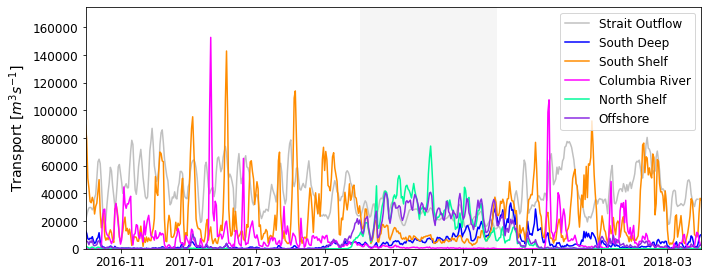

In [99]:
fig, ax = plt.subplots(1,1, figsize=(10,4))
plt.rcParams['font.size'] = 12
ax.plot(dates[:-(N-1)], loop_avg, label = "Strait Outflow", c='silver')
# ax.plot(dates, loop, label = "Strait Outflow", c='silver')
ax.plot(dates, cuc, label = "South Deep", c='b')
ax.plot(dates, south, label = "South Shelf", c='darkorange')
ax.plot(dates, fresh, label = "Columbia River", c='magenta')
ax.plot(dates, north, label = "North Shelf", c='mediumspringgreen')
ax.plot(dates, offshore, label = "Offshore", c='blueviolet')
ax.legend(loc='upper right')
ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
# ax.set_ylim([0,55000]);
ax.set_ylim([0,175000])
ax.set_xlim([dates[0],dates[-1]])

ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke')

plt.tight_layout()
# plt.savefig("./figures/dailyWMtoJRT.pdf")



In [40]:
cols = ['#YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD','GST']
wind = pd.read_csv('lapush.csv', usecols=cols, sep=",", header=0).drop(0)
wind.drop(wind[wind.WDIR == '999 9'].index, inplace=True)
wind = wind.dropna()

for i in wind.index:
    if ' ' in wind.WSPD[i]:
        wind.drop(i, inplace=True)

<ipython-input-40-89fdedc49a72>:2: DtypeWarning: Columns (0,1,2,3,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  wind = pd.read_csv('lapush.csv', usecols=cols, sep=",", header=0).drop(0)


In [41]:
# lets have a subplot with wind speed and direction at la push
# wind = pd.read_csv('desw.csv', usecols=['#YY', 'MM', 'DD', 'hh', 'mm', 'WDIR', 'WSPD'], header=0).drop(0)
d = {'year':wind['#YY'],'month':wind['MM'],'day':wind['DD'],'hour':wind['hh'],'minute':wind['mm']}
w_date = pd.DataFrame(d)
wind['datetime'] = pd.to_datetime(w_date)
wind = wind.set_index('datetime')

wind['WDIR'] = pd.to_numeric(wind['WDIR'])
wind['WSPD'] = pd.to_numeric(wind['WSPD'])
wind['Wrad'] = np.deg2rad(wind['WDIR'])
wind['northward'] = wind['WSPD']*np.cos(wind['WDIR'])

In [43]:
d = np.array(wind['northward']).reshape(-1, 1)
clf = LOF(n_neighbors=10)
clf.fit_predict(d)
lof10 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=100)
clf.fit_predict(d)
lof100 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=1000)
clf.fit_predict(d)
lof1000 = abs(clf.negative_outlier_factor_)

clf = LOF(n_neighbors=2000)
clf.fit_predict(d)
lof2000 = abs(clf.negative_outlier_factor_)

# make array of the data removed for plotting
rem10 = d[lof10 > 2]
time10 = wind.index[lof10 > 2]
rem100 = d[lof100 > 2]
time100 = wind.index[lof100 > 2]
rem1000 = d[lof1000 > 2]
time1000 = wind.index[lof1000 > 2]
rem2000 = d[lof2000 > 2]
time2000 = wind.index[lof2000 > 2]

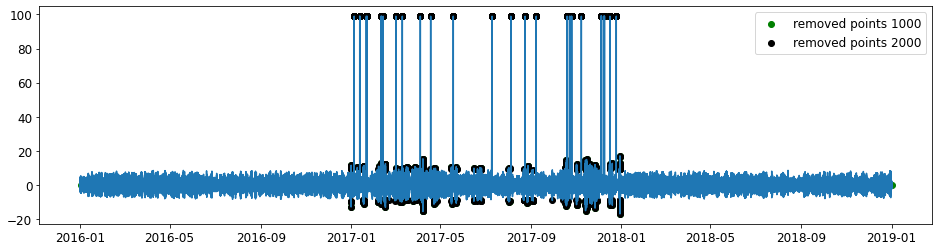

In [53]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(wind.northward)

# ax.scatter(time10, rem10, c='k', label='removed points 10')
# ax.scatter(time100, rem100, c='b', label='removed points 100')
# ax.scatter(time1000, rem1000, c='g', label='removed points 1000')
ax.scatter(time2000, rem2000, c='r', label='removed points 2000')
ax.legend()

In [70]:
wind.drop(time2000,inplace=True)
wind = wind.resample('D').mean()

(17075.0, 17621.0)

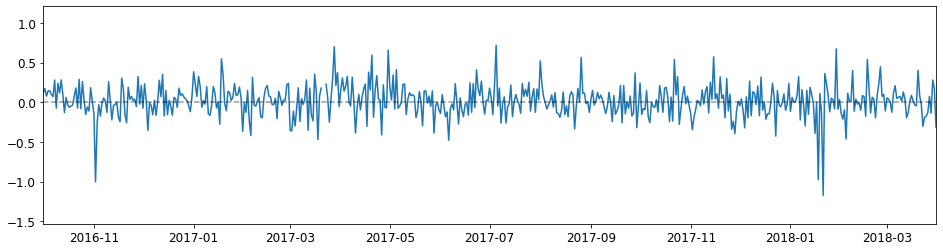

In [59]:
fig, ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(wind.northward)
ax.plot([dates[0],dates[-1]],[0,0],'k--',alpha=0.4)
ax.set_xlim([dates[0],dates[-1]])


Text(0.99, 0.8, 'Poleward')

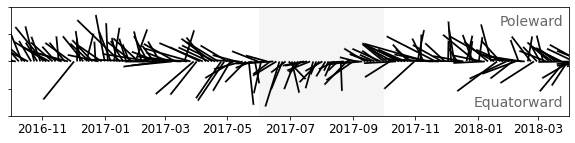

In [98]:
wind_4 = wind.resample('3D').mean()

U = np.cos(wind_4.Wrad) * wind_4.WSPD
V = np.sin(wind_4.Wrad) * wind_4.WSPD

fig, ax = plt.subplots(1,1,figsize=(10,2))
ax.quiver(wind_4.index,np.zeros(len(wind_4.index)),U,V, headwidth=0,scale=50)
ax.set_ylim([-1,1])
ax.set_xlim([dates[0],dates[-1]])
ax.set_yticklabels([])

ax.fill_between(np.array(dates), -2,2, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke',zorder=0)
ax.text(.99, .05, "Equatorward", ha='right', va='bottom', alpha=0.6, transform=ax.transAxes, fontsize=14)
ax.text(.99, .80, "Poleward", ha='right', va='bottom', alpha=0.6, transform=ax.transAxes, fontsize=14)


In [126]:
# ok lets bring in Fraser River and Columbia River flow
# fraser at hope:
fraser = pd.read_csv('daily_20231124T1831.csv',header=1) # https://wateroffice.ec.gc.ca/download/index_e.html?results_type=historical
fraser.drop(fraser.index[fraser.PARAM == 2],inplace=True)
fraser['Date'] = pd.to_datetime(fraser.Date)
fraser = fraser.set_index('Date')

# columbia at Vancouver washington
columb = pd.read_csv('columbia_vancouverWA.txt',header=27, sep='\t').drop(0) # https://waterdata.usgs.gov/nwis/uv?site_no=14144700&legacy=1
columb['flow'] = pd.to_numeric(columb['218412_00060'])/35.315 # convert from cubic feet to m3
columb['datetime'] = pd.to_datetime(columb.datetime)
columb = columb.set_index('datetime')
columb = columb.resample('D').mean()


<ipython-input-126-fd12f4f436a3>:11: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  columb = pd.read_csv('columbia_vancouverWA.txt',header=27, sep='\t').drop(0) # https://waterdata.usgs.gov/nwis/uv?site_no=14144700&legacy=1


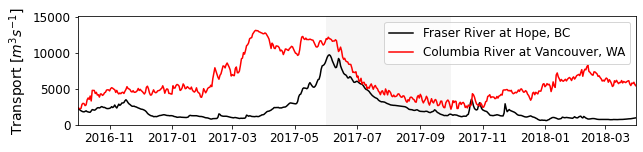

In [143]:
fig, ax = plt.subplots(1,1,figsize=(10,2))

ax.set_xlim([dates[0],dates[-1]])
ax.set_ylim([0,15100])
ax.plot(fraser.Value,'k',label='Fraser River at Hope, BC')
ax.plot(columb.flow, 'r', label='Columbia River at Vancouver, WA')
ax.legend()
ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
ax.fill_between(np.array(dates), -10,15200, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke',zorder=0)


In [146]:
from matplotlib.gridspec import GridSpec


Text(0.01, 0.82, 'c)')

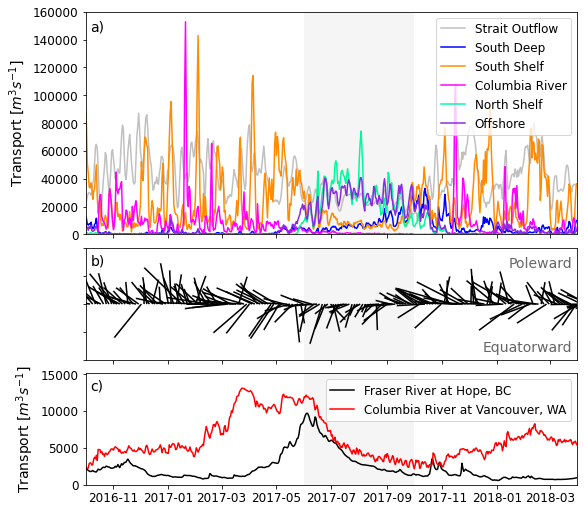

In [160]:
# all three plots of interest together
# fig, ax = plt.subplots(3,1, figsize=(10,10))
plt.rcParams['font.size'] = 12

fig = plt.figure(constrained_layout=True, figsize=[8,7])
gs = GridSpec(8, 1, figure=fig)
ax0 = fig.add_subplot(gs[:4,0])
ax1 = fig.add_subplot(gs[4:6,0])
ax2 = fig.add_subplot(gs[6:,0])

for axs in [ax0,ax1,ax2]:
    axs.set_xlim([dates[0],dates[-1]])
    axs.fill_between(np.array(dates), -10,200000, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke')


# water mass flow 
ax0.plot(dates[:-(N-1)], loop_avg, label = "Strait Outflow", c='silver')
ax0.plot(dates, cuc, label = "South Deep", c='b')
ax0.plot(dates, south, label = "South Shelf", c='darkorange')
ax0.plot(dates, fresh, label = "Columbia River", c='magenta')
ax0.plot(dates, north, label = "North Shelf", c='mediumspringgreen')
ax0.plot(dates, offshore, label = "Offshore", c='blueviolet')
ax0.legend(loc='upper right')
ax0.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
ax0.set_ylim([0,160000])
ax0.set_xticklabels([])
ax0.text(.01, .9, 'a)', ha='left', va='bottom', transform=ax0.transAxes, fontsize=14)

# wind variability
ax1.quiver(wind_4.index,np.zeros(len(wind_4.index)),U,V, headwidth=0,scale=50)
ax1.set_ylim([-1,1])
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.text(.99, .05, "Equatorward", ha='right', va='bottom', alpha=0.6, transform=ax1.transAxes, fontsize=14)
ax1.text(.99, .80, "Poleward", ha='right', va='bottom', alpha=0.6, transform=ax1.transAxes, fontsize=14)
ax1.text(.01, .82, 'b)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=14)


# river flow
ax2.set_ylim([0,15100])
ax2.plot(fraser.Value,'k',label='Fraser River at Hope, BC')
ax2.plot(columb.flow, 'r', label='Columbia River at Vancouver, WA')
ax2.legend()
ax2.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
ax2.text(.01, .82, 'c)', ha='left', va='bottom', transform=ax2.transAxes, fontsize=14)



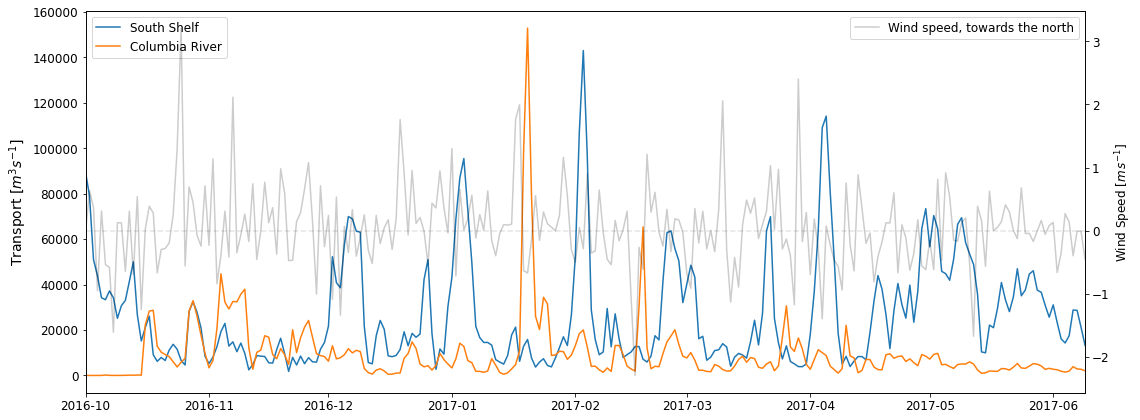

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.rcParams['font.size'] = 12
ax.plot(dates, south, label = "South Shelf")
ax.plot(dates, fresh, label = "Columbia River")

ax2 = ax2=ax.twinx()
ax2.plot(wind.index,wind.northward,c='k', label='Wind speed, towards the north', alpha = 0.2)
ax2.plot([dates[0],dates[-1]],[0,0],'k--',alpha=0.1)
ax2.set_ylabel('Wind Speed [$m\,s^{-1}$]')
ax2.plot()
# ax2.quiver(wind.index,np.zeros(len(wind.index)),U,V, headwidth=0,scale=100)
# ax2.plot(wind.index,wind.WDIR,'k--',label='wind direction', alpha = 0.3)

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_ylabel('Transport [$m^{3}s^{-1}$]',fontsize=14)
# ax.set_ylim([0,55000]);
# ax.set_ylim([0,200000])
ax.set_xlim([dates[0],dates[251]])

# ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke', alpha=0.4)

plt.tight_layout()
plt.savefig("./figures/columbiawind.pdf")

Text(0, 0.5, 'Cumulative Transport [$m^{3}s^{-1}$]')

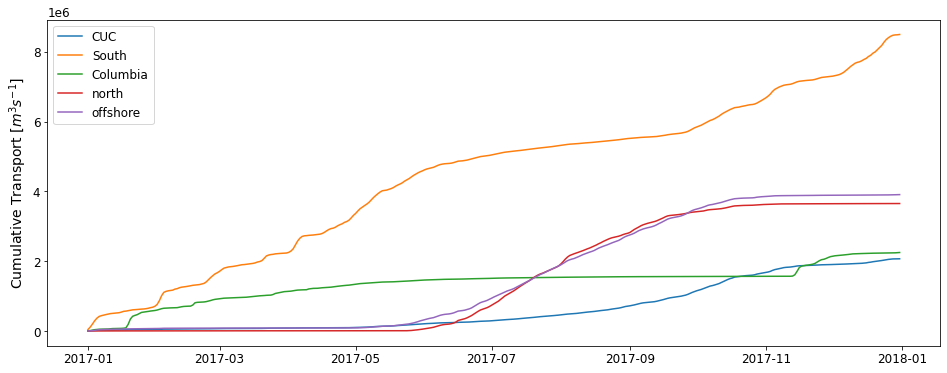

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
plt.rcParams['font.size'] = 12
ax.plot(dates[92:457], np.cumsum(cuc[92:457]), label = "CUC")
ax.plot(dates[92:457], np.cumsum(south[92:457]), label = "South")
ax.plot(dates[92:457], np.cumsum(fresh[92:457]), label = "Columbia")
ax.plot(dates[92:457], np.cumsum(north[92:457]), label = "north")
ax.plot(dates[92:457], np.cumsum(offshore[92:457]), label = "offshore")
ax.legend(loc='upper left')
ax.set_ylabel('Cumulative Transport [$m^{3}s^{-1}$]',fontsize=14)

In [ ]:
# lets calculate the peason's correlation coefficient between north and offhsore in the summer
corr, _ = pearsonr(north[243:364], offshore[243:364])
print('Pearsons correlation with offshore: %.3f' % corr)
corr, _ = pearsonr(north[243:364], cuc[243:364])
print('Pearsons correlation with cuc: %.3f' % corr)
corr, _ = pearsonr(north[243:364], south[243:364])
print('Pearsons correlation with south: %.3f' % corr)
corr, _ = pearsonr(cuc[243:364], south[243:364])
print('Pearsons correlation cuc and south summer: %.3f' % corr)

Pearsons correlation with offshore: 0.684
Pearsons correlation with cuc: -0.092
Pearsons correlation with south: -0.105
Pearsons correlation cuc and south summer: 0.169


In [16]:
corr, _ = pearsonr(np.append(fresh[:215],fresh[364:]), np.append(south[:215],south[364:]))
print('Pearsons correlation fresh and south winter: %.3f' % corr)
corr, _ = pearsonr(np.append(cuc[:215],cuc[364:]), np.append(south[:215],south[364:]))
print('Pearsons correlation cuc and south winter: %.3f' % corr)
corr, _ = pearsonr(np.append(cuc[:215],cuc[364:]), np.append(fresh[:215],fresh[364:]))
print('Pearsons correlation cuc and fresh winter: %.3f' % corr)
corr, _ = pearsonr(np.append(south_shallow[:215],south_shallow[364:]), np.append(fresh[:215],fresh[364:]))
print('Pearsons correlation south shallow and fresh winter: %.3f' % corr)
# can't say conclusion about columbia and south inverse correlation... :/ 

Pearsons correlation fresh and south winter: -0.118
Pearsons correlation cuc and south winter: 0.292
Pearsons correlation cuc and fresh winter: -0.204
Pearsons correlation south shallow and fresh winter: 0.031


(0.0, 150000.0)

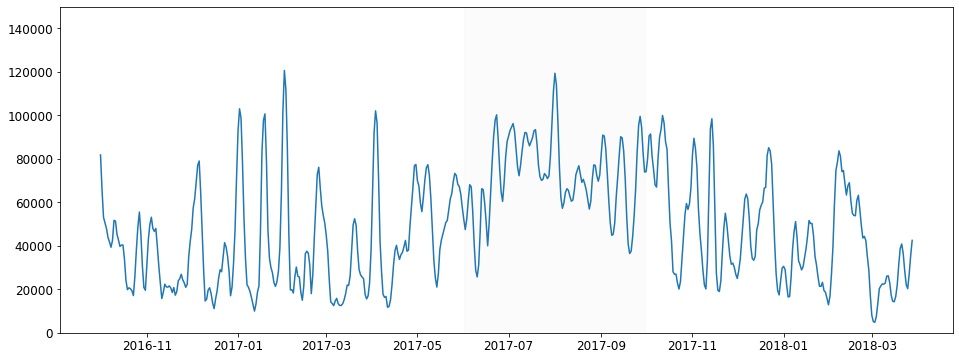

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
N=4
ax.plot(dates[:-(N-1)], np.sum([running_mean(cuc, N),running_mean(fresh, N),running_mean(north, N),running_mean(south, N),running_mean(offshore, N)],axis=0))
# ax.set_ylim([0,90000]);
ax.fill_between(np.array(dates), 0,200000, where=(np.array(dates)<=dates[364])&(np.array(dates)>dates[242]), color='whitesmoke', alpha=0.4)
ax.set_ylim([ 0,150000])